As a whole, we have decided to do our analysis on crime data because many of us have started seeing rampant rise in accidents, crimes, and an overall surplus of crimes in our hometowns. We started wondering, if we can see this in our hometowns, is it the same in other counties, towns, cities, and if so, is there a way that we can predict if in certain areas crime is more rampant. What if a certain group of people tends to be more targeted than others? Are there some areas that are more rampant in crime than others? This is the basis of why wanted to make the analysis on this dataset, especially with one from a big county such as Los Angeles County. 

The dataset that we are using comes directly from the Los Angeles Police Department, and represents all crimes that have been reported from 2020 to November 23rd, 2024. Although there are many different features we can look at, the ones we will be using are: 

DATE OCC (the total date in the form MM/DD/YYYY)

TIME OCC (the time in military time)

AREA (the area where the closest LAPD's community police station is)

AREA NAME (the name of the geographical area)

Rpt Dist No (the four-digit area code)

Crm Cd (the police crime code of crime committed)

Crm Cd Desc (a written description of the crime)

Vict Age (the victim's age), Vict Sex (the victim's sex)

Vic Descent (the victim's ethnicity)

Premis Desc (defines the premise code)

LAT (latitude of location)

LON (longitude of location)

Our overall goal for this project was to see if we can find any patterns within the crimes being committed in Los Angeles. From these patterns, we were wondering if it would be possible to predict the type of crime based on features, or predict different features using the type of crime. To this end, we developed 5 hypotheses that we tackled in total.

Can we predict the type of crime given the victim’s description?

Do certain areas form distinct crime “hotspots”


Can we predict/deduce if a certain ethnicity is targeted more than the others?
 
Can we predict the age of a victim based on the area and the type of cri m
e?
Does grouping the types of crime into more general groups allow for easier predictions of crime analysis by gen der?


**Hypothesis 1**

For this section of the project, we wanted to see if it would be possible to determine the crime being committed based on features of the victim. Futhermore, we wanted to test this with both supervised learning (using KNN and KD-Tress) and unsupervised learning (using K-Means), with hopes that

To start with the unsupervised analysis, we wanted to get a baseline of the data we would be working with. Below is the extremely filtered version of the data from the dataset, specifically the victim's age, the victim's sex, and the victim's descent (as in race).

The data we got from the LAPD has a variety of crimes involved. The main issue with this is that many crimes do not have a victim in mind, such as stolen vehicles, petty theft, and grand theft. These crimes have the victim's details marked as X, 0, or -1. To handle this, we removed all entries with an X or O or -1 within the victim's description (used to represent no victim / unspecified feature). Furthermore, a lot of the crimes of committed were not common, so any crimes with less than 2000 entries were removed as to improve performance. This was all done as to simplify the features to make them to use when using clustering.

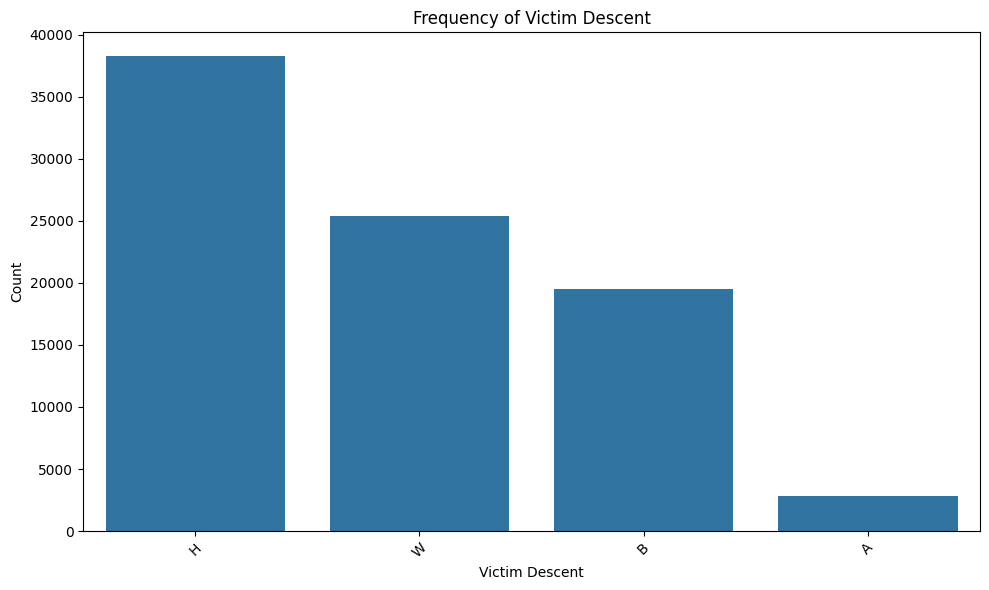

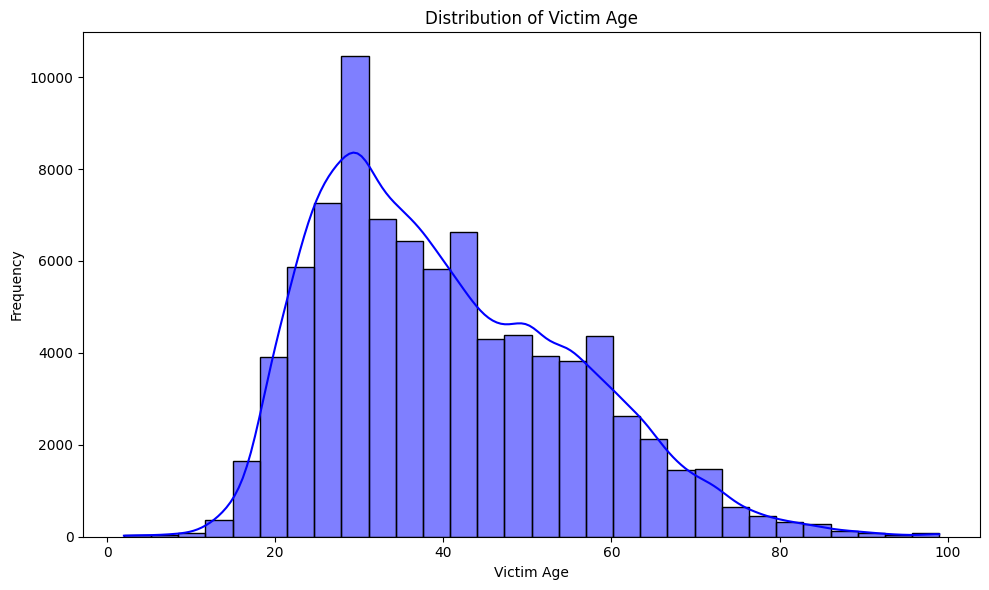

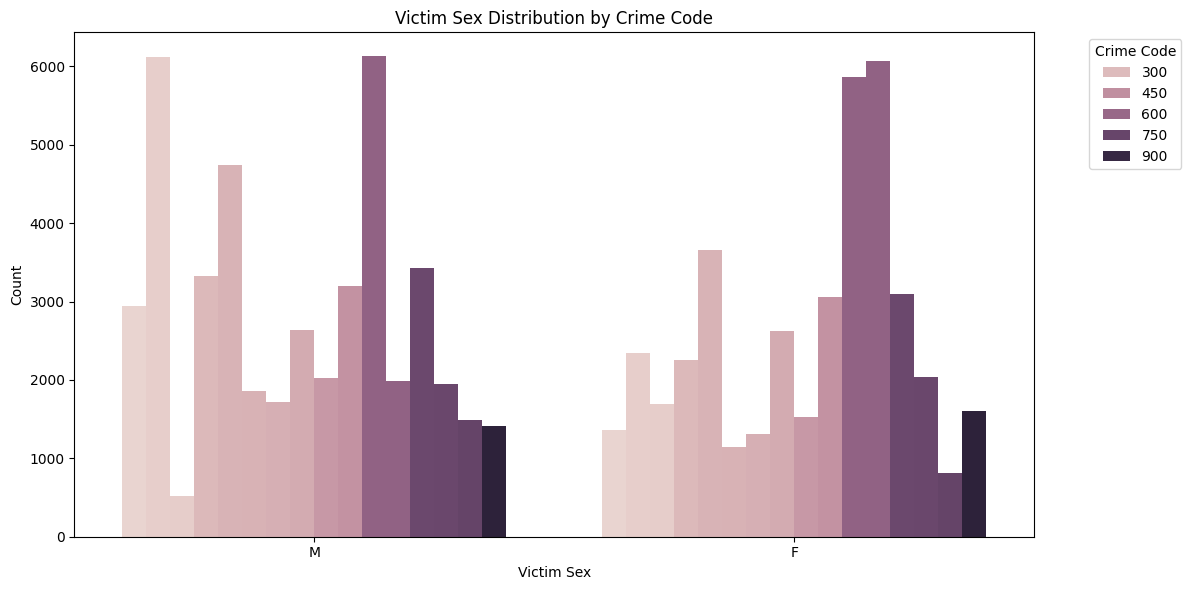

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

file_path = 'Crime_Data_from_2020_to_Present.csv'
df = pd.read_csv(file_path)

#selecing features
relevant_columns = ['Crm Cd', 'Vict Descent', 'Vict Age', 'Vict Sex']
df = df[relevant_columns]

#looking for data that is usable
df = df[df['Vict Age'] > 0]

df = df[df['Vict Sex'] != 'X']

df = df[df['Vict Descent'] != 'X']

df = df[df['Vict Descent'] != 'O']

#looking for more than 2000 entries
crime_counts = df['Crm Cd'].value_counts()
valid_crimes = crime_counts[crime_counts >= 2000].index
df = df[df['Crm Cd'].isin(valid_crimes)]

descent_counts = df['Vict Descent'].value_counts()
valid_descents = descent_counts[descent_counts >= 2000].index
df = df[df['Vict Descent'].isin(valid_descents)]

sex_counts = df['Vict Sex'].value_counts()
valid_sexes = sex_counts[sex_counts >= 2000].index
df = df[df['Vict Sex'].isin(valid_sexes)]

#frequency distribution of victim descent
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Vict Descent', order=df['Vict Descent'].value_counts().index)
plt.title('Frequency of Victim Descent')
plt.xlabel('Victim Descent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#victim age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Vict Age', bins=30, kde=True, color='blue')
plt.title('Distribution of Victim Age')
plt.xlabel('Victim Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#victim sex distribution per crime code
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Vict Sex', hue='Crm Cd')
plt.title('Victim Sex Distribution by Crime Code')
plt.xlabel('Victim Sex')
plt.ylabel('Count')
plt.legend(title='Crime Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

All the victim's features were ultimately chosen to be used for the clustering, as all three could have influence over the crime being committed.

There are still some facts to note about this cleaned data:
- There is a gender imbalance between the males and females, which has to be normalized.
- There is gender imbalance within crimes themselves, which has to be normalized.
- There is an age skew towards the 30s, which must be normalized.
- There is a descent imbalance between the remaining ethnicities, which has to be normalized.

Using this data, my next goal was to perform the elbow method to see which k should be used for k-means, and then follow that by performing k-means on the different selected features.

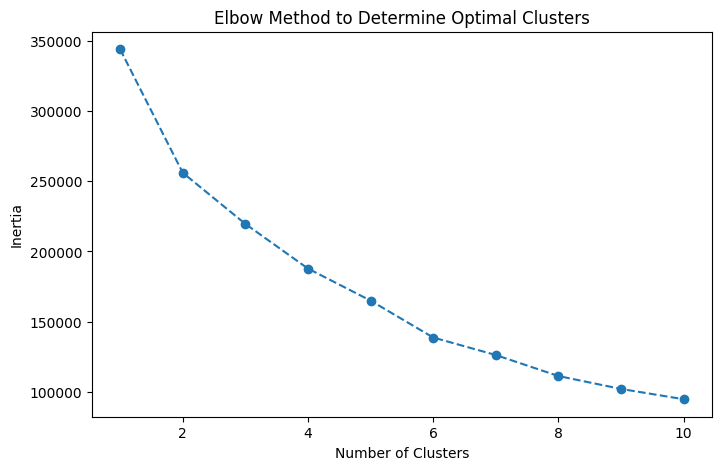

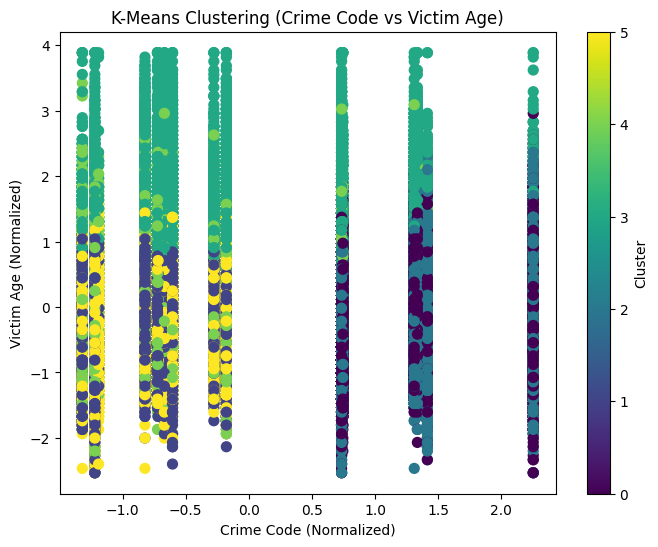

Cluster Summary (Mean):
             Crm Cd  Vict Descent   Vict Age  Vict Sex
Cluster                                               
0        688.495326      1.808146  36.002059  0.000000
1        312.231911      2.416208  35.505938  1.000000
2        709.833212      2.034083  37.634300  1.000000
3        432.862568      2.607669  65.403807  0.540119
4        353.195018      0.725291  42.612271  0.890555
5        322.257203      2.012812  34.863639  0.000000
Cluster Summary (Mode):
         Crm Cd  Vict Descent  Vict Age  Vict Sex
Cluster                                          
0           626             2        28         0
1           230             2        30         1
2           624             2        30         1
3           624             3        62         1
4           230             1        30         1
5           330             2        29         0


In [ ]:
#encoding categorical for clustering
label_encoders = {}
for col in ['Vict Descent', 'Vict Sex']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#features in clustering
X = df[['Crm Cd', 'Vict Descent', 'Vict Age', 'Vict Sex']]

#normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

#graph the elbow method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

#mkeans with elbow method
kmeans = KMeans(n_clusters=6, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

#visualizae clustering
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 2], c=df['Cluster'], cmap='viridis', s=50)
plt.title('K-Means Clustering (Crime Code vs Victim Age)')
plt.xlabel('Crime Code (Normalized)')
plt.ylabel('Victim Age (Normalized)')
plt.colorbar(label='Cluster')
plt.show()

#mean and mode of each cluster
print("Cluster Summary (Mean):")
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)

cluster_summary = df.groupby('Cluster').agg(lambda x: x.mode().iloc[0])
print("Cluster Summary (Mode):")
print(cluster_summary)

There are two things to note with the clustering. Firstly, although the elbow method should cutoff at k=2, the clustering naturally splits based off the sex, which is not the clustering we are looking for. We were wanting the clustering to separate into groups that we could use to group types of crime. To fix this, we went for the next most obvious elbow in the graph which occurs at k=6. At this point in the data, each cluster was uniquely different, but not to the degree that we were hoping for. To visualize this, I found the Principal Component Analysis will allow us to visualize the data in a 2D graph, showing how the clusters roughly group together. Since the PCA was not covered in this class, the basics is to take the two most variant components to the cluster and use it to show the clusterings. Below is this graph.

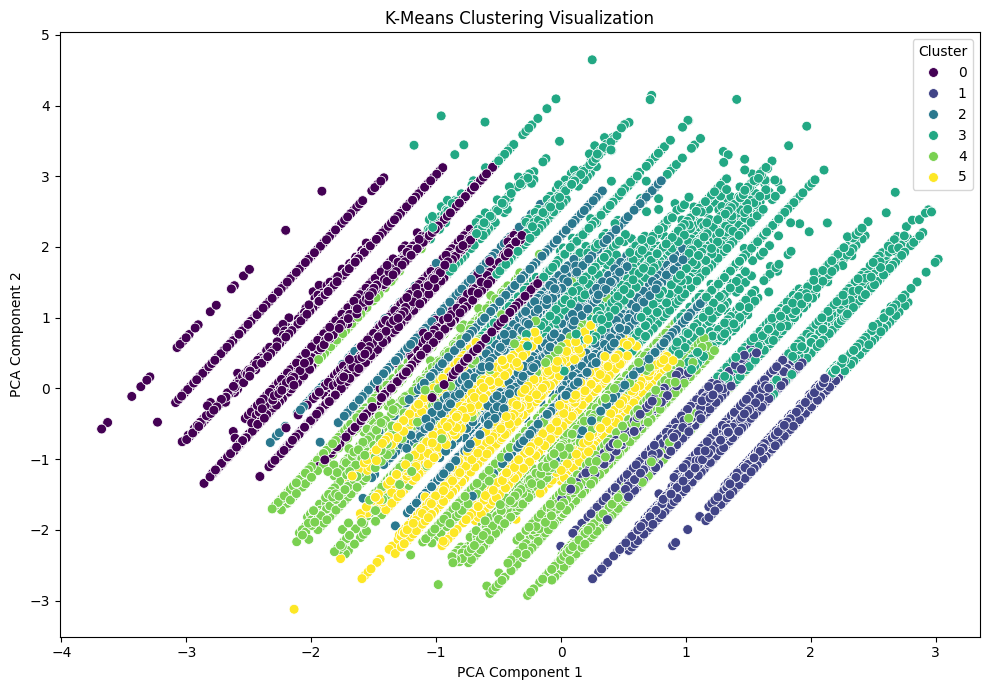

In [ ]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components and cluster labels to the dataframe for visualization
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)
plt.title('K-Means Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

**Conclusion pt 1**

A signature of how to tell if a PCA Visualization is good is to see if the clusters do not overlap, however as can be seen the clusters overlap severly. This means that the clusters are not good, however these clusters are also the best clusters we can form. From this, we can concluded that from this data it is not possible to form well meaning clusters, and at best can only partially guess a crime based on the victim's description.

**Hypothesis 1 cont**

For the supervised analysis, we wanted to see if it was possible to achieve a similar goal as described with unsupervised analysis, specfically if we could determine a crime based off of a victim's description.

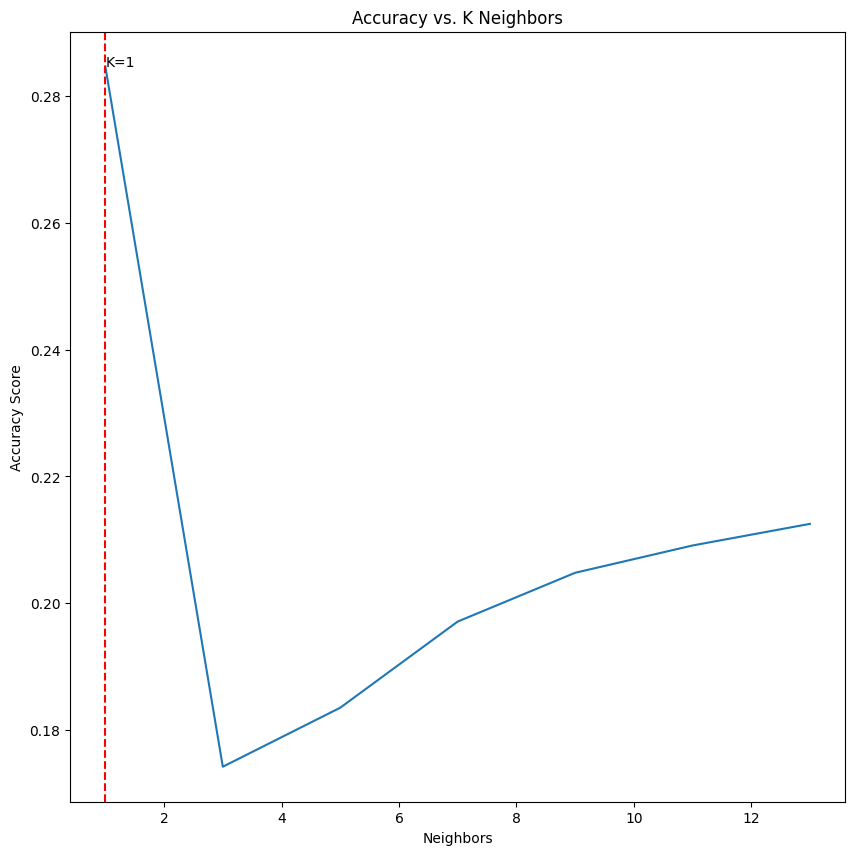

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

crime_data_m = pd.read_csv("Crime_Data_from_2020_to_Present.csv")
crime_data_m["DATE OCC ONLY"] = crime_data_m["DATE OCC"].astype(str).str[:10]
crime_data_m["MONTH OCC"] = crime_data_m["DATE OCC ONLY"].str[:2].astype(int)
crime_data_m["DAY OCC"] = crime_data_m["DATE OCC ONLY"].str[3:5].astype(int)
crime_data_m["YEAR OCC"] = crime_data_m["DATE OCC ONLY"].str[6:10].astype(int)

age_col = crime_data_m[["Vict Age"]]
crime_data_m.drop(columns=["Vict Age"])
age_scaler = StandardScaler()
crime_data_m["Vict Age (standardized)"] = age_scaler.fit_transform(age_col)

crime_data_m["TIME OCC (hrs)"] = (crime_data_m["TIME OCC"] // 100) + ((crime_data_m["TIME OCC"] % 100) / 60)
crime_data_m["TIME OCC (sin)"] = np.sin(2 * np.pi * crime_data_m["TIME OCC (hrs)"] / 24)
crime_data_m["TIME OCC (cos)"] = np.cos(2 * np.pi * crime_data_m["TIME OCC (hrs)"] / 24)

crm_cd_le = LabelEncoder()
crime_data_m["Crm Cd (encoded)"] = crm_cd_le.fit_transform(crime_data_m["Crm Cd"])

group1 = crime_data_m[crime_data_m["Vict Sex"].isin(['M','F'])].copy()
group2 = crime_data_m[~crime_data_m["Vict Sex"].isin(['M','F'])].copy()

sex_encoder = LabelEncoder()
group1["Vict Sex Binary"] = sex_encoder.fit_transform(group1["Vict Sex"])

sex_log_reg = LogisticRegression()
x_train = group1[["TIME OCC (sin)", "TIME OCC (cos)", "Crm Cd (encoded)", "Vict Age (standardized)"]]
y_train = group1["Vict Sex Binary"]

x_test = group2[["TIME OCC (sin)", "TIME OCC (cos)", "Crm Cd (encoded)", "Vict Age (standardized)"]]
sex_log_reg.fit(x_train, y_train)

y_pred = sex_log_reg.predict(x_test)

group2["Vict Sex Binary"] = y_pred
group2.drop(columns=["Vict Sex"])

crime_data_m = pd.concat([group1, group2], axis=0)

X = crime_data_m[['AREA', 'Vict Age (standardized)', 'Vict Sex Binary',
                     'TIME OCC (sin)', 'TIME OCC (cos)', 'MONTH OCC', 'YEAR OCC']]
y = crime_data_m['Crm Cd (encoded)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

max_accuracy = 0
best_k = 0
k_values = []
corresp_accuracy = []
for k_val in range(1,15,2):

    knn_classifier = KNeighborsClassifier(n_neighbors=k_val)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    k_values.append(k_val)
    corresp_accuracy.append(accuracy)
    if (accuracy > max_accuracy):
        max_accuracy = accuracy
        best_k = k_val

fig, ax = plt.subplots(figsize = (10, 10))
max_ind = np.argmax(corresp_accuracy)
ax.plot(k_values, corresp_accuracy)
ax.axvline(x=k_values[max_ind], linestyle='--', color='r')
ax.text(k_values[max_ind], max(corresp_accuracy), f'K={k_values[max_ind]}')
ax.set_title("Accuracy vs. K Neighbors")
ax.set_xlabel("Neighbors")
ax.set_ylabel("Accuracy Score")
plt.show()

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=201, weights='distance')
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.3326031090702279


Above shows the overall best accuracy that we were able to achieve using this model. At a 31.71% accuracy, we believe that this model is not nearly accurate enough for proper predictions. Our original model only used k=1, which although isn't something that can't be done, means that the model is not running using proper k usage. To fix this, we wanted to try to make a model that uses better k and also used weight voting to prioritze closer neighbors. This led us to use k=201. However, this model had a high runtime which caused us to try to find a faster model while still preserving as much accuracy as possible.

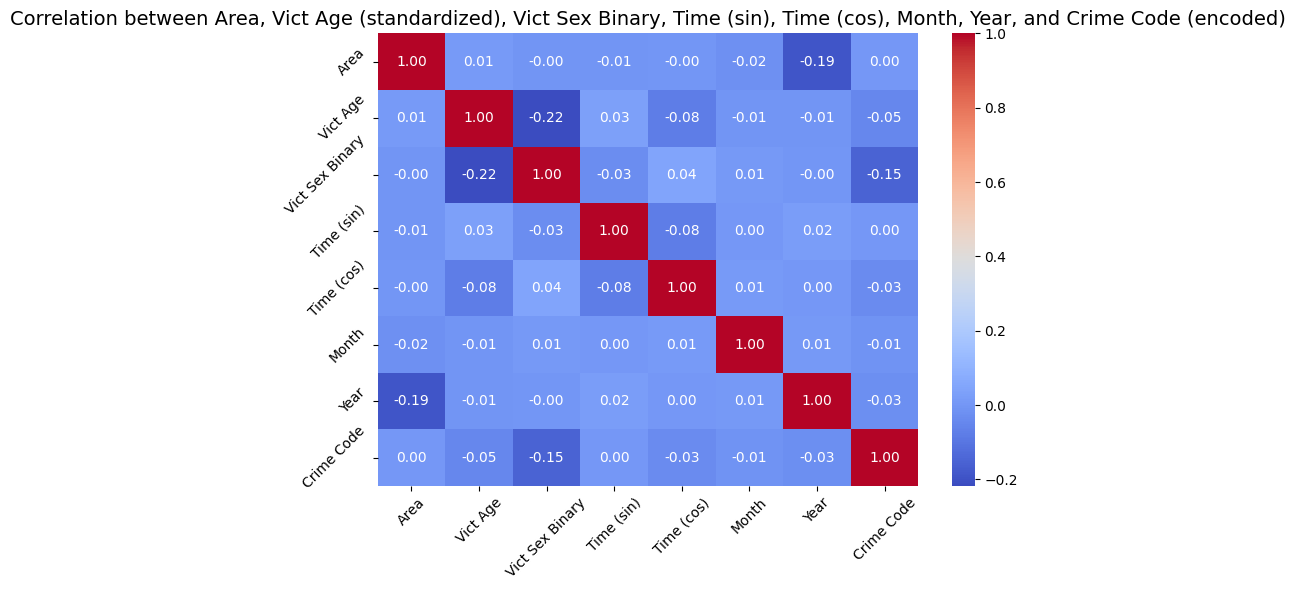

In [ ]:
corr_data = crime_data_m[['AREA', 'Vict Age (standardized)', 'Vict Sex Binary', 'TIME OCC (sin)', 'TIME OCC (cos)', 'MONTH OCC', 'YEAR OCC', 'Crm Cd (encoded)']]
corr_matrix = corr_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Area, Vict Age (standardized), Vict Sex Binary, Time (sin), Time (cos), Month, Year, and Crime Code (encoded)', fontsize=14)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], labels=['Area', 'Vict Age', 'Vict Sex Binary', 'Time (sin)', 'Time (cos)', 'Month', 'Year','Crime Code'], rotation=45)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], labels=['Area', 'Vict Age', 'Vict Sex Binary', 'Time (sin)', 'Time (cos)', 'Month', 'Year','Crime Code'], rotation=45)
plt.tight_layout()
plt.show()

The correlation matrix above shows that variables such as Area, TIME OCC (sin), and MONTH OCC had little to no correlation to the Crime Code variable meaning that these variables did not help much in predicting which crime a person may be victim to. Therefore, we trained a model that used less features to see if the runtime and/or accuracy would improve.

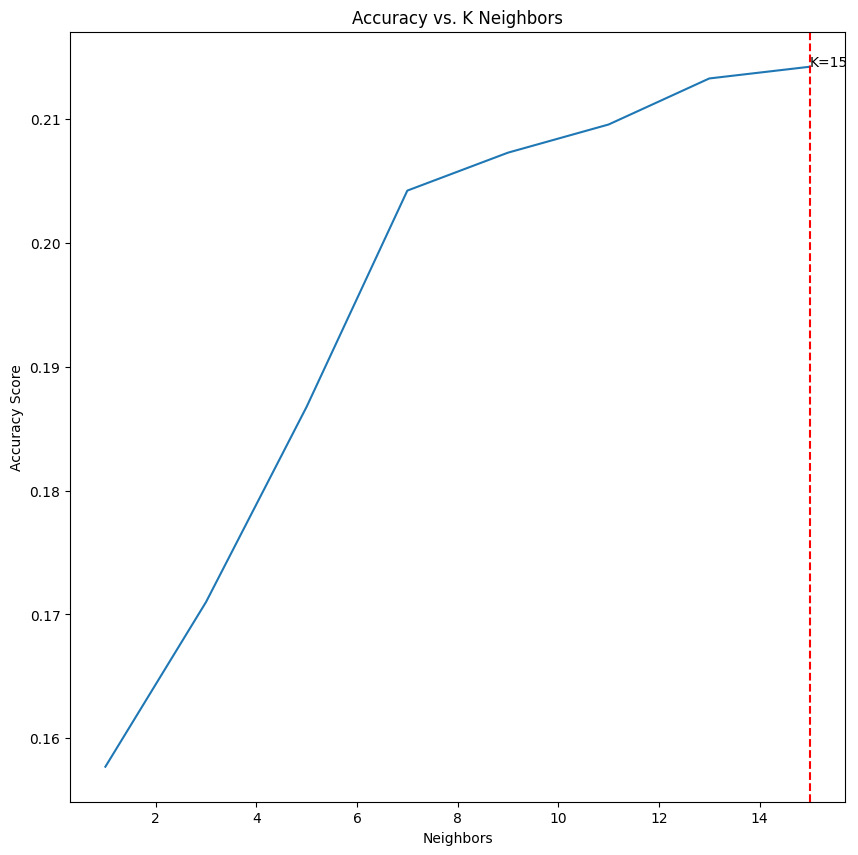

0.22634494670767158


In [ ]:
X2 = crime_data_m[['Vict Sex Binary','Vict Age (standardized)', 'TIME OCC (cos)', 'YEAR OCC']]
y2 = crime_data_m['Crm Cd (encoded)']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.20)
max_accuracy2 = 0
best_k2 = 0
k_values2 = []
corresp_accuracy2 = []
for k_val in range(1,16,2):

    knn_classifier = KNeighborsClassifier(n_neighbors=k_val, weights='distance')
    knn_classifier.fit(X_train2, y_train2)
    y_pred = knn_classifier.predict(X_test2)
    accuracy = accuracy_score(y_test2, y_pred)

    k_values2.append(k_val)
    corresp_accuracy2.append(accuracy)
    if (accuracy > max_accuracy2):
        max_accuracy2 = accuracy
        best_k2 = k_val

fig, ax = plt.subplots(figsize = (10, 10))
max_ind2 = np.argmax(corresp_accuracy2)
ax.plot(k_values2, corresp_accuracy2)
ax.axvline(x=k_values2[max_ind2], linestyle='--', color='r')
ax.text(k_values2[max_ind2], max(corresp_accuracy2), f'K={k_values2[max_ind2]}')
ax.set_title("Accuracy vs. K Neighbors")
ax.set_xlabel("Neighbors")
ax.set_ylabel("Accuracy Score")
plt.show()

knn_classifier = KNeighborsClassifier(n_neighbors=201, weights='distance')
knn_classifier.fit(X_train2, y_train2)
y_pred = knn_classifier.predict(X_test2)
accuracy = accuracy_score(y_test2, y_pred)
print(accuracy)

Above we see that the runtime is lower than before and the graph shows that if we continue to increase k, the accuracy may improve. However, this defeats the original purpose of trying to decrease runtime. In order to improve runtime, we impliment a model that uses a kd-tree as well so that we can train a model that uses the same amount of features and neighbors while preserving accuracy.

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=201, weights='distance', algorithm='kd_tree')
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'{accuracy*100:.2f}%')

33.26%


The above accuracy shows that our goal was accomplished, but we believed that we could still improve the accuracy.

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size = 0.01)

knn_classifier = KNeighborsClassifier(n_neighbors=501, weights='distance', algorithm='kd_tree', metric='manhattan')
knn_classifier.fit(X_train3, y_train3)
y_pred = knn_classifier.predict(X_test3)
accuracy = accuracy_score(y_test3, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 36.16%


In [ ]:
print(f'Samples in 99% training set: {int(len(crime_data_m)*0.99)}')

Samples in 99% training set: 469991


In [ ]:
print(f'Samples in 1% testing set: {int(len(crime_data_m)*0.01)}')

Samples in 1% testing set: 4747


**KNN Classifier** After trying many different models we found that the above model performed the best. Throughout our training we found that a KNN Classifier that uses weight voting to prioritize closer neighbors, a kd tree, and uses the Manhattan distance measure rather than the default Euclidean algorithm led to the highest accuracy. We also found that a bigger training set allowed for the model to generalize patterns better. This model uses a 99% training set from our entire data which translates to 974,204 samples that the model can learn from. The testing set consists of 1% of the data, or 9,840 samples, which is still reasonable.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train3, y_train3)
accuracy_dtc = decision_tree.score(X_test3,y_test3)

print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 36.16%


**Decision Tree Classifier** We also found that a Decision Tree Classifier ran faster, but still led to the same amount of accuracy which further supported our claim.

**Conclusion** 

From these two models we have concluded as a group that attempting to predict a crime given a victim's description and information about when the crime took place is not effective. There are too many confounding variables that make it difficult to properly form a prediction despite whichever model was used. We found this very surprising as we were expecting to be able to accurately predict a crime based on these features. This may be due to the fact that predicting what crime a person might be victim to is a very complex problem. Personally, we feel that crimes nowadays are very unpredictable. Also, the fact that we have few observations for certain crimes makes it difficult for the model to generalize patterns to predict for these crimes.

**Hypothesis 2**

In this test, I want to check if certain areas have a distinct crime that's commonly related to the area you're in. Thankfully the columns we'll use are formatted and cleaned already due to the columns being required for each police report. After that we'll swap the categorial data to numerical and feature them in the clustering.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

crime_data = pd.read_csv("Crime_Data_from_2020_to_Present.csv")

crime_data = crime_data.dropna(subset=['LAT', 'LON', 'Crm Cd Desc', 'Premis Desc'])
crime_data = crime_data[(crime_data['LAT'] != 0) & (crime_data['LON'] != 0)]

# swapped categorial data to numerical using LabelEncoder()
le_crm = LabelEncoder()
crime_data['Crm_Cd_Desc_Encoded'] = le_crm.fit_transform(crime_data['Crm Cd Desc'].astype(str))
le_prem = LabelEncoder()
crime_data['Premis_Desc_Encoded'] = le_prem.fit_transform(crime_data['Premis Desc'].astype(str))

# Features for clustering
X = crime_data[['LAT', 'LON', 'Crm_Cd_Desc_Encoded', 'Premis_Desc_Encoded']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Now we'll use the elbow method to determine the most optimal amount of k values for K-means.

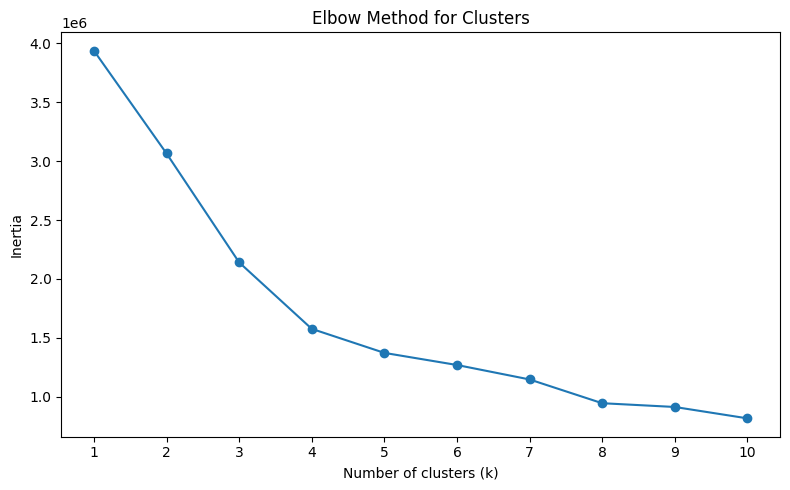

In [ ]:
# Elbow Method
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method for Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.tight_layout()
plt.show()

From the graph shown, 7 seems to be a good K value we can use. So we'll be using this value for the algorithm.

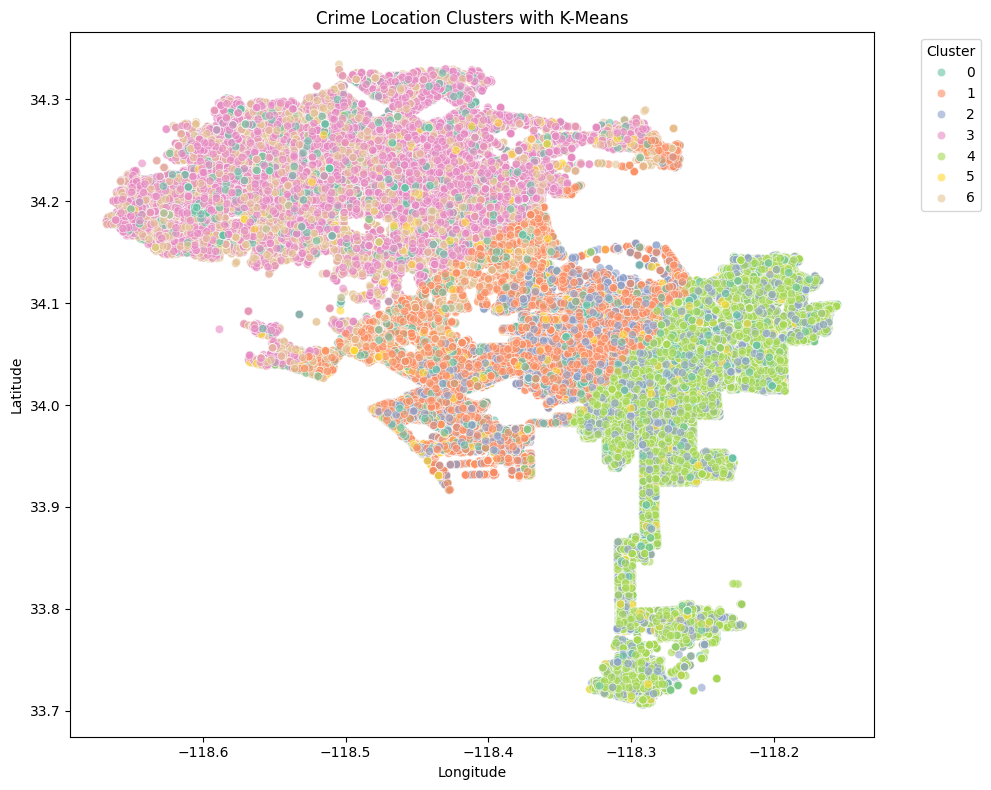

In [ ]:
num_clusters = 7

# Apply KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=82)
labels = kmeans.fit_predict(X_scaled)

crime_data['Cluster'] = labels

cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

# scatterplots of LAT and LON coordinates
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='LON',
    y='LAT',
    hue='Cluster',
    palette='Set2',
    data=crime_data,
    alpha=0.6
)
plt.title('Crime Location Clusters with K-Means')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Conclusion**

The K-Means clustering results support the hypothesis that crime is not randomly distributed across the city. Although some areas such as the northern area has a more spread out cluster, there were clear signs of dominant crimes in the northern, eastern, and southern sides of Los Angeles. As such it is clear that these clusters suggest that some areas are known for specific crimes such as theft or assaults.


**Hypothesis 3**

In this case, I wanted to see if there were any correlations or if it were possible to see cetain ethnicites are being targeted more frequently than others in certain areas/regions of the LA County.

In order to do this we first have to clean the data to make sure that it is being passed through correctly and we can determine our analysis to be done thoroughly.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder


crimeData = pd.read_csv('/content/Crime_Data_from_2020_to_Present.csv')
#adding unknown as an extra
crimeData['Vict Descent'] = crimeData['Vict Descent'].fillna('Unknown')
#helps clean the data more by standardizing it.
crimeData.columns = [col.strip().replace(' ', '_').lower() for col in crimeData.columns]

Now lets go ahead and start with our analysis since our data has now been cleaned and standardized. This should allow for the data to be analyzed swiftly and without problems. We first made sure that our data where ethnicites were missing, we replace it with an unknown since we also want to take that into consideration.

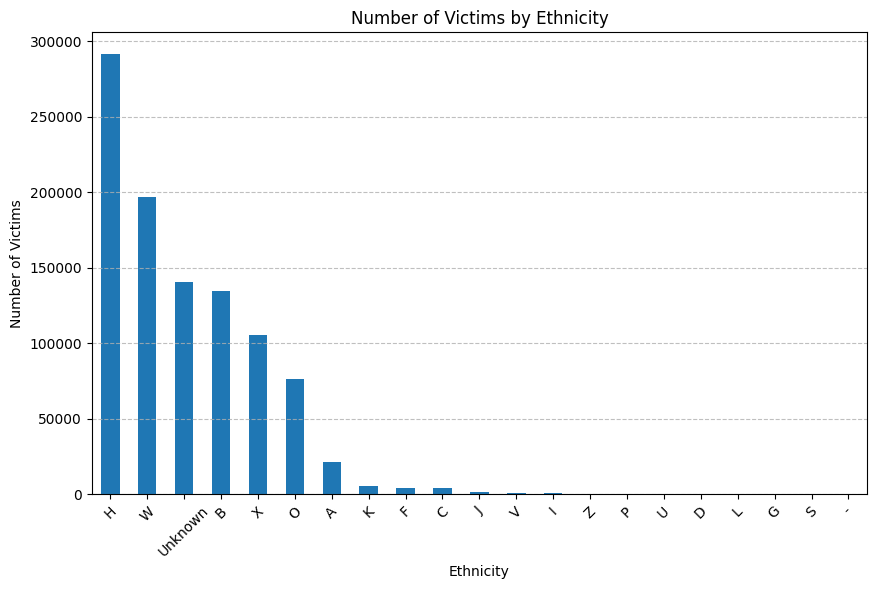

In [ ]:
#the data is now being grouped by 'vict_descent' the count of victims
victim_ethnicity_counts = crimeData['vict_descent'].value_counts()

plt.figure(figsize=(10, 6))
victim_ethnicity_counts.plot(kind='bar')
plt.title('Number of Victims by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Victims')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.show()

In this graph, we can now see how many victims there are per ethnicity here. This will now help guide us on our goal, which is to see if a certain ethnicity gets targeted more than others in certain areas.

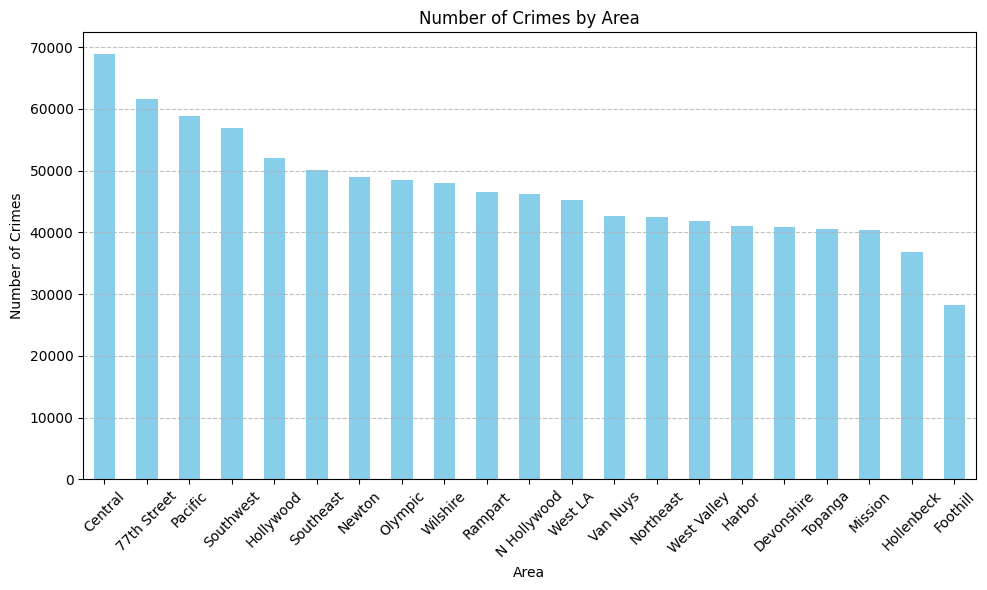

In [ ]:
#group by 'area_name' and count the number of crimes in that location
crimes_by_area = crimeData['area_name'].value_counts()

plt.figure(figsize=(10, 6))
crimes_by_area.plot(kind='bar', color='skyblue')
plt.title('Number of Crimes by Area')
plt.xlabel('Area')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

Now here, we can see the amount of crimes commited per area of LA county. Now that we have this total amount of crimes we should be able to run some analysis on our data to see if we are right or wrong on our hypothesis.

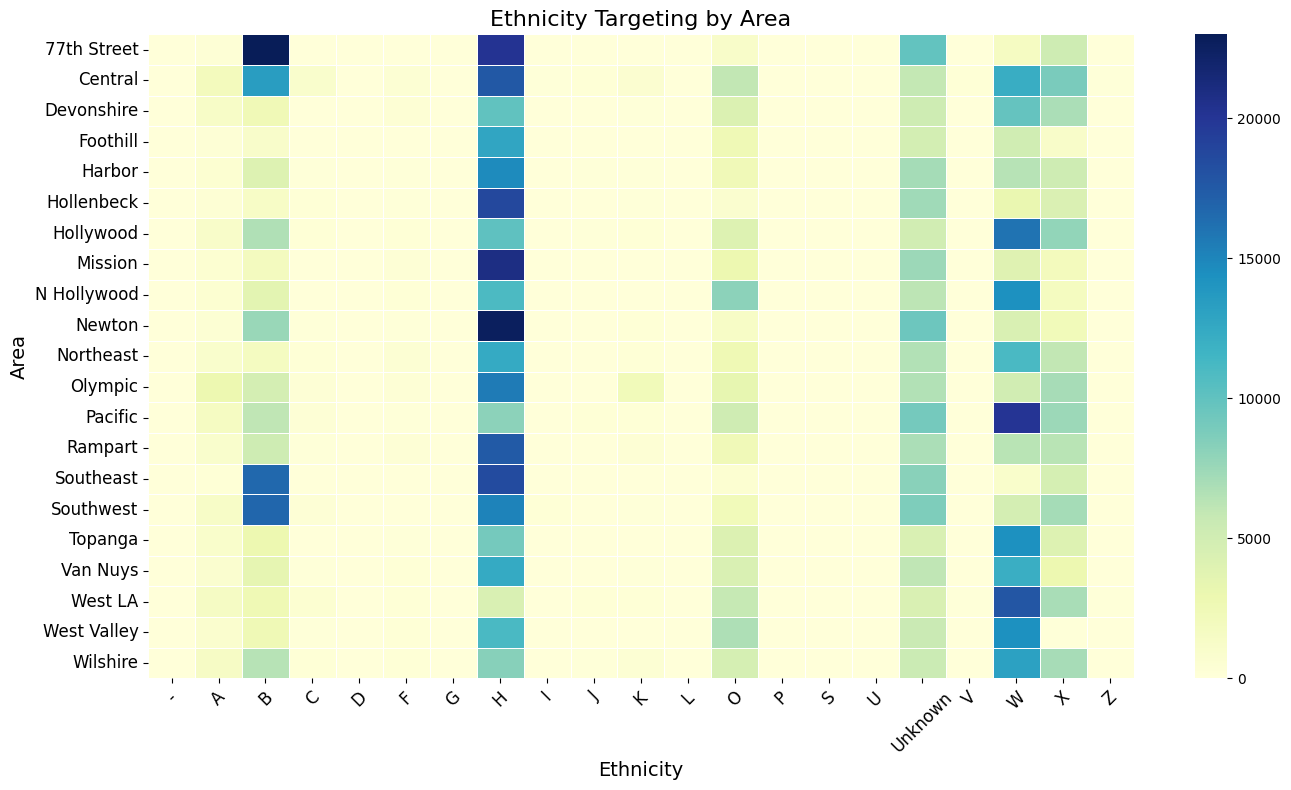

In [ ]:
#group by area_name and vict_descent now we count occurrences of it
ethnicity_area_counts = crimeData.groupby(['area_name', 'vict_descent']).size().unstack(fill_value=0)

#heatmap to make it look nice
plt.figure(figsize=(14, 8))
sns.heatmap(ethnicity_area_counts, annot=False, cmap='YlGnBu', linewidths=.5)
plt.title('Ethnicity Targeting by Area', fontsize=16)
plt.xlabel('Ethnicity', fontsize=14)
plt.ylabel('Area', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Now we can see how the analyzed crimes affect our victims of certain ethnicities. It looks like we might get something here since we can see that B, and H ethnicity are the most heavily dense victims. Will this prove that some ethincities are more likely to be targeted by our perpetrators?

Classification Report:

              precision    recall  f1-score   support
A              0.000000  0.000000  0.000000    6352.0
B              0.354039  0.294854  0.321747   40420.0
C              0.000000  0.000000  0.000000    1329.0
D              0.000220  0.269231  0.000439      26.0
F              0.008156  0.233901  0.015763    1351.0
G              0.000000  0.000000  0.000000      20.0
H              0.449770  0.043572  0.079448   87441.0
I              0.003675  0.218750  0.007229     288.0
J              0.000000  0.000000  0.000000     454.0
K              0.010447  0.088563  0.018689    1705.0
L              0.000135  0.090909  0.000271      22.0
O              0.169189  0.193834  0.180675   22901.0
P              0.000000  0.000000  0.000000      84.0
S              0.000325  0.250000  0.000648      16.0
U              0.000728  0.209677  0.001451      62.0
Unknown        0.000000  0.000000  0.000000   42186.0
V              0.001155  0.052326  0.002260     344.0
W   

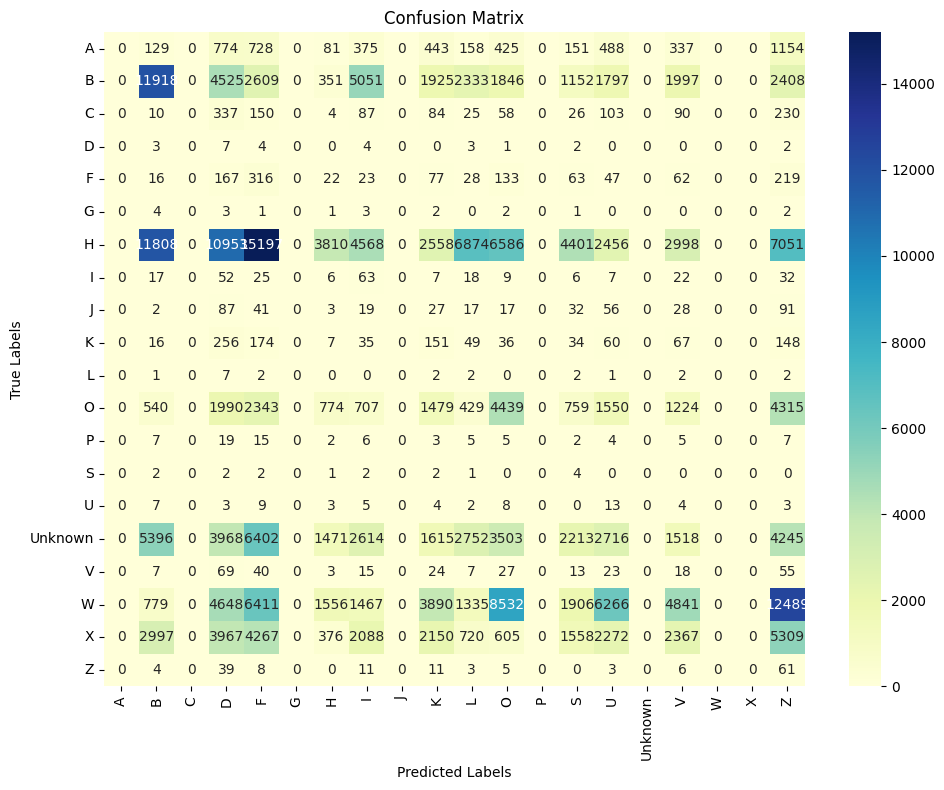

In [ ]:
#independent
features = crimeData[['area_name']]
#dependent
target = crimeData['vict_descent']
#encoder time
encoder = OneHotEncoder(sparse_output=False, drop='first')
#transform the area name
encoded_features = encoder.fit_transform(features[['area_name']])
#make the desecent into numeric to predict
target_encoded = target.astype('category').cat.codes
#train test time.
X_train, X_test, y_train, y_test = train_test_split(
    encoded_features,       #matrix (X)
    target_encoded,         #variable (y)
    test_size=0.3,          #set size is 30%
    random_state=42,        #ensures that it is reproducible
    stratify=target_encoded #distribution is consistent
)
#moment of truth with the algorithm.
model = RandomForestClassifier(
    n_estimators=100,       #number of trees in the forest
    random_state=42,        #makes sure its reproducible
    class_weight='balanced' #makes sure its balanced
)
#choo choo train it now
model.fit(X_train, y_train)
#predictions time
y_pred = model.predict(X_test)
#make a test to see if there are some correlations
uniqueEthnicity = np.unique(y_test)
target_names_in_test = target.astype('category').cat.categories[uniqueEthnicity]
#report here
report_dict = classification_report(
    y_test,
    y_pred,
    labels=uniqueEthnicity, #this one shows our tests on ethnicity
    target_names=target_names_in_test,
    output_dict=True
)
#show the report
report_df = pd.DataFrame(report_dict).transpose()
print("Classification Report:\n")
print(report_df)
#confusion matrix time to see if we hit or if we missed3
conf_matrix = confusion_matrix(y_test, y_pred, labels=uniqueEthnicity)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=target_names_in_test,
    yticklabels=target_names_in_test
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

Our plan here was to use some type of supervised learning model, and while making some research we have learned about random forest. This algorithm should help with our large data set to determine if we had some correlatins between our ethnicities and crime areas. We can see by our matrix and our report how each ethnicity is targeted by area.

**Conclusion**

Unfortunately, if we follow the data visuatlizations and the classification report. We can see that there is not muuch strong correlation or slighly hints that we are able to predict/say that a cetain group of people gets targeted more often or is more likely to be targeted. We can indedd see that some groups, such s B and H do indeed get targeted more frequently. But this is not strong enough to be certain. We do indeed see hints that it might be true but for now it can also be to many other factors that were not taken into consideration.

**Hypothesis 4:**

Are we able to predict the age of a victim depending on the area and type of crime commited?

In the code, I shrunk down the data set so that I could focus on only the columns I needed. I indexed by time so that I could use the time, area, and crime occured to predict the age of a victim. Victim age had some problematic data with values of age that were incorrect. There were way to many victims that were above the age of 80 compared to younger victims which is not realistic so I set 80 as the max age. There was also crimes with no age associated to them because they had no victims. I decided to completely omit these since they were not needed in what I am trying to accomplish. I split the data set into a training set and a testing set so that I could perform a knn regression on it. I random sampled 1000 out of the 900000 plus data points to perform this knn regression. Before I did this I performed I did it on all the data points and discovered that doing this did not effect my results. In the end this would make the visualizations more clear.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
age_df = pd.read_csv("Crime_Data_from_2020_to_Present.csv", index_col = "TIME OCC")
age_df_filtered = age_df.drop(columns=["LON", "LAT", "Cross Street", "LOCATION", "Crm Cd 4", "Crm Cd 3", "Crm Cd 2", "Crm Cd 1", "Status Desc", "Status", "Weapon Desc", "Weapon Used Cd", "Premis Desc", "Premis Cd", "Vict Descent", "Vict Sex", "Mocodes", "Crm Cd Desc", "Part 1-2", "Rpt Dist No", "DATE OCC", "Date Rptd", "DR_NO"])
age_df_filtered = age_df_filtered[age_df_filtered["Vict Age"] <= 80]
age_df_filtered = age_df_filtered[age_df_filtered["Vict Age"] >= 5]
age_df_filtered = age_df_filtered.sample(n=1000, random_state=42)
age_train = age_df_filtered.loc[age_df_filtered.index <= 1200].copy()
age_test = age_df_filtered.loc[age_df_filtered.index > 1200].copy()
age_df_filtered.head()

,AREA,AREA NAME,Crm Cd,Vict Age
TIME OCC,,,,
1335,20,Olympic,230,19
1140,3,Southwest,888,23
2220,16,Foothill,624,29
1630,2,Rampart,210,32
2100,3,Southwest,440,22


This is basic scatter plot to visualize the data and there distances between each other.

<Axes: xlabel='Crm Cd', ylabel='AREA'>

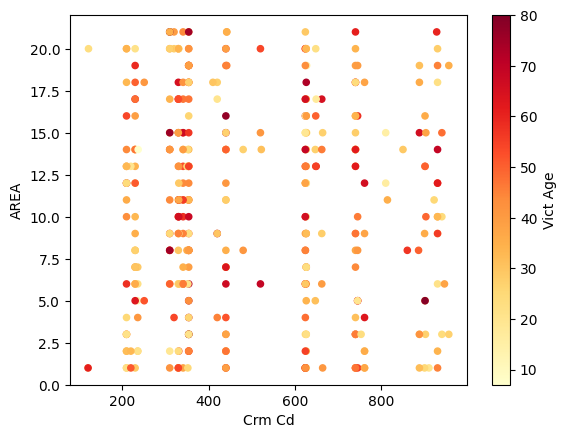

In [ ]:
age_train.plot.scatter(x="Crm Cd", y="AREA", c="Vict Age", cmap=cm.YlOrRd)

I extracted the training data and scaled the different features.

In [ ]:
X_train = age_train[["Crm Cd", "AREA"]]
y_train = age_train["Vict Age"]

X_train_mean = X_train.mean()
X_train_sd = X_train.std()
X_train_st = (X_train - X_train_mean) / X_train_sd

X_train_st

,Crm Cd,AREA
TIME OCC,,
1140,1.767435,-1.220853
1000,-0.244234,-1.220853
1100,1.956030,1.383634
930,1.197163,1.220853
15,-1.160262,-0.569732
...,...,...
100,0.689755,0.406951
730,-0.738171,-1.546414
300,-0.738171,-0.244171


Here we get the featues for the new time of 3pm and standardize it.

In [ ]:
x_new = age_test.loc[1500][["Crm Cd", "AREA"]].median()

x_new_st = (x_new - X_train_mean) / X_train_sd
print(x_new_st)

Crm Cd    0.581987
AREA      0.081390
dtype: float64


In [ ]:
dists = np.sqrt(((X_train_st - x_new_st) ** 2).sum(axis=1))
dists

,0
TIME OCC,
1140,1.761001
1000,1.542232
1100,1.893101
930,1.294920
15,1.859944
...,...
100,0.342934
730,2.095845
300,1.359709


Below I did k-fold cross validation on our data to find which k would work best for our model. I calculated the testing error since we want to base our models performance on how well it performs with data it hasn't seen. I found k equal to 20 to be the best k to use without introducing to much bias or variance by testing different k's. Anything higher did not change the test error enough for it to be significant. After I found a good k I calculated the Euclidean distance between its nearest neighbors.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor

pipeline = make_pipeline(
          StandardScaler(),
          KNeighborsRegressor(n_neighbors=20)
    )
pipeline.fit(X=X_train, y=y_train)

scores = cross_val_score(pipeline,
                         X=age_train[["Crm Cd", "AREA"]],
                         y=age_train["Vict Age"],
                         scoring="neg_mean_squared_error",
                         cv=4)
scores
print(np.sqrt(-scores).mean())

i_nearest = dists.sort_values().index[:20]
i_nearest

15.169249182174354


Index([1200,  825, 1100,  530,    1,  900, 1030,  420, 1020,  815,  830,  130,
       1200,  950,  100,  800, 1200, 1200,  930, 1000],
      dtype='int64', name='TIME OCC')

In [ ]:
age_train.loc[i_nearest]

,AREA,AREA NAME,Crm Cd,Vict Age
TIME OCC,,,,
1200,16,Foothill,626,26
1200,12,77th Street,930,52
1200,9,Van Nuys,662,28
1200,10,West Valley,624,56
1200,6,Hollywood,662,40
...,...,...,...,...
1000,1,Central,900,25
1000,1,Central,888,32
1000,6,Hollywood,341,28


In [ ]:
y_train_ = y_train.loc[i_nearest].mean()
print(y_train_)

43.56370656370656


This is a prediction of time 1500 military time which transfers to 3pm regular time. At this time we predicted the age of a victim will be approximately 43 years old using features crime commited and area.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

X_train = age_train[["AREA"]]
y_train = age_train["Vict Age"]

model = KNeighborsRegressor(n_neighbors=20)
model.fit(X=X_train, y=y_train)

KNeighborsRegressor(n_neighbors=20)

Here I am trying to best fit a knn regression model to our data. I chose a k of 20 after trial and error of k-fold cross validation to see which k would make the model fit our data the best without creating to much bias or variance.

<Figure size 2000x1200 with 0 Axes>

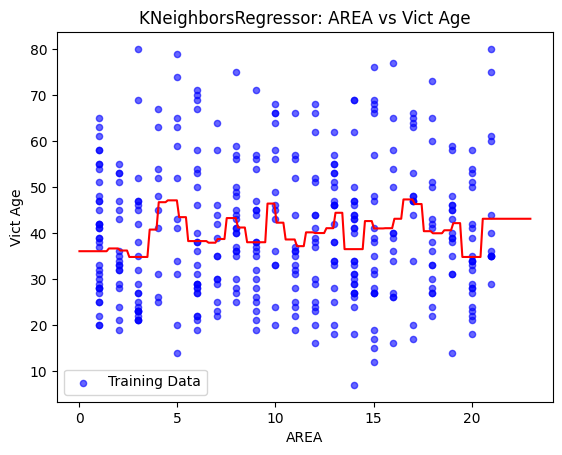

In [ ]:
X_new = pd.DataFrame()
X_new["AREA"] = np.linspace(0, 23, num=200)

y_new = pd.Series(
    model.predict(X_new),
    index=X_new["AREA"]
)

plt.figure(figsize=(20, 12))
age_train.plot.scatter(x="AREA", y="Vict Age", label="Training Data", color="blue", alpha=0.6)
y_new.plot.line(label="Predictions", color="red")
plt.title("KNeighborsRegressor: AREA vs Vict Age")
plt.xlabel("AREA")
plt.ylabel("Vict Age")
plt.show()

This is the knn regression for predicting victim age based of the area of crimes commited. The blue dots are the training data and the redline represents our model. As you can see our models prediction falls in line with our prediction above.

In [ ]:
X_train = age_train[["Crm Cd"]]
y_train = age_train["Vict Age"]

model = KNeighborsRegressor(n_neighbors=20)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20)

Here I am trying to best fit a knn regression model to our data. I chose a k of 20 after trial and error of k-fold cross validation to see which k would make the model fit our data the best without creating to much bias or variance.

<Figure size 2000x1200 with 0 Axes>

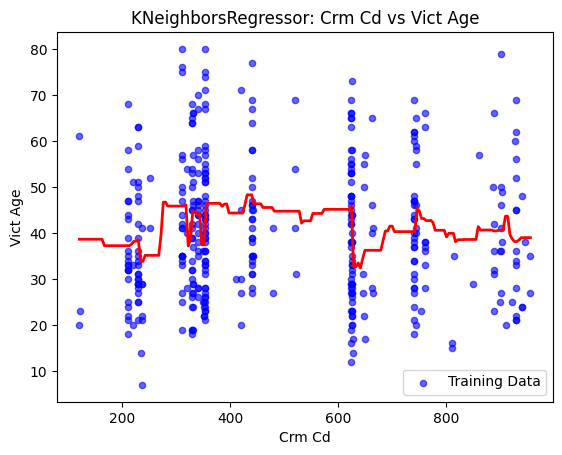

In [ ]:
min_crm = X_train["Crm Cd"].min()
max_crm = X_train["Crm Cd"].max()
X_new = pd.DataFrame({"Crm Cd": np.linspace(min_crm, max_crm, num=200)})

y_new = model.predict(X_new)

plt.figure(figsize=(20, 12))

age_train.plot.scatter(x="Crm Cd", y="Vict Age", label="Training Data", color="blue", alpha=0.6)

plt.plot(X_new["Crm Cd"], y_new, label="Predictions", color="red", linewidth=2)

plt.title("KNeighborsRegressor: Crm Cd vs Vict Age")
plt.xlabel("Crm Cd")
plt.ylabel("Vict Age")
plt.show()

This is the knn regression for predicting victim age based on the crime that was committed. The blue dots are the training data and the redline represents our model. As you can see our models prediction falls in line with our prediction above.

Starting out with k equal 10 we chose a decent k for our model. This resulted in a testing error of 16. In terms of age this was definitely on the higher end of error than expected. By increasing k we hoped to better our prediction, but we had to ensure that we did not allow to much bias to enter in. When using k equals 20 the testing error decreased to 15. K larger than 20 barely affected the testing error from this point on. Based on our results our model is alright for predictions of victim age based on crime committed and area. All of the knn regressions performed  for this hypothesis gave similar results as well.

**Hypothesis 5** 

Would grouping the types of crime into more general groups allow for easier predictions of crime?

In [ ]:
df['date_time'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p').dt.date
df['date'] = pd.to_datetime(df['date_time']).dt.strftime('%m/%d/%Y')

df['year'] = df['date'].str[-4:]
df['month'] = df['date'].str[:2]


##### Below is a visual analysis of crime density based on gender (M, F, X). This visual includes analysis all 139 different crime types, which provides a very cluttered and hard to read bar chart. WHen there are som many x variables, it makes it difficult to analyze catagorical data. I believe that by grouping the crimes into broader categories, we can optimize our analysis and run more optomized predictive models

In [ ]:
df = df.dropna(subset=['Crm Cd', 'Vict Sex'])

crime_gender_counts = df_filter.groupby(['Crm Cd', 'Vict Sex']).size().unstack(fill_value=0)

crime_gender_counts.plot(
    kind='bar', 
    stacked=True, 
    figsize=(14, 8),
    colormap='viridis'
)

plt.title('Crime Type Distribution by Gender (Male, Female, X)')
plt.xlabel('Crime Type')
plt.ylabel('Number of Crimes')
plt.legend(title='Gender')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

First thing I did was take all of the different crime types and sort them into 6 new broader categories: Violent Crimes, property crimes, white collar crimes, organized crimes, personal/sexual crimes, and OTHER. I identified certain keywords to help me create the groupings. The hope is that by creating broader categories and focusing more on the nature of the different crime types rather than each individual crime occurance, we would be able to generate analysis that was both easier to visually analyze and would run better as a predictive model. 


In [ ]:
df['Crm Cd Desc'] = df['Crm Cd Desc'].str.lower().str.strip()

# Enhanced mapping function with partial matching
def map_crime_type(crime):
    crime = crime.lower()  # Ensure consistency in case
    if any(keyword in crime for keyword in ['assault', 'battery', 'rape', 'homicide', 'kidnapping', 'threat', 'lynching', 'shots', 'weapon', 'cruelty']):
        return 'violent_crime'
    elif any(keyword in crime for keyword in ['burglary', 'theft', 'vandalism', 'arson', 'vehicle', 'stolen', 'trespassing', 'shoplifting', 'pickpocket', 'robbery', 'snatching']):
        return 'property_crime'
    elif any(keyword in crime for keyword in ['fraud', 'embezzlement', 'extortion', 'counterfeit', 'forgery', 'bribery', 'bunco', 'document']):
        return 'white_collar_crime'
    elif any(keyword in crime for keyword in ['trafficking', 'pimping', 'pandering', 'organized']):
        return 'organized_crime'
    elif any(keyword in crime for keyword in ['lewd', 'drugs', 'exposure', 'violence', 'disturbing', 'reckless', 'prowler', 'violation', 'indecent', 'peace', 'reckless', 'annoying', 'dumping', 'peeping','sex','beastiality', 'scare', 'disperse',
                                                 'stalking','pornography', ]):
        return 'personal/sexual_crime'
    else:
        return 'OTHER'

# Apply the improved mapping function
df['Grouped_Crm Cd Desc'] = df['Crm Cd Desc'].apply(map_crime_type)

# Verify the mapping results
print(df[['Grouped_Crm Cd Desc']].value_counts())

grouped_crimes = df.groupby('Grouped_Crm Cd Desc')['Crm Cd Desc'].unique()
for category, crimes in grouped_crimes.items():
    print(f"\nCategory: {category}\nCrimes: {crimes}")

above shows the different crimes that went into the new groupings.
 
I then created stacked bar charts with the grouped crimes data to see if I could more easily spot a correlation. At first I didn’t normalize the data, which made the crime categories with more crime types stand out, as seen above. The categories live property crime and violent crimes had more variety of grouped crimes within, but normalizing gave me more of a trend to work with and helped smooth out the uneven data distribution (bottom graph)
What I found was that m
Male victi were more prone to experiences: property, violent, & white-collar crim, while f
Fems were more likely to be victimt ofms: organized & personal/sexal  cri. mes


In [ ]:
crime_gender_counts = df.groupby(['Grouped_Crm Cd Desc', 'Vict Sex']).size().unstack(fill_value=0)
normalized_data = crime_gender_counts.div(crime_gender_counts.sum(axis=1), axis=0) * 100

#non-normalized
crime_gender_counts.plot(
    kind='bar', 
    stacked=True, 
    figsize=(14, 8),
    colormap='viridis')

plt.title('Crime Type Distribution by Gender (Male, Female, X)')
plt.xlabel('Crime Type')
plt.ylabel('Number of Crimes')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#normalized
ax = normalized_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    cmap='viridis',
    alpha=0.8)

plt.title('Normalized Crime Type Distribution by Gender (Male, Female, X)')
plt.xlabel('Crime Type')
plt.ylabel('Number of Crimes')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Using these new crime distributions, I ran KNN analysis in order to see if we could use victim gender, age, and crime area location to predict the type of crime one is likely to experience based on these features. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Crime_Data_from_2020_to_Present.csv')


df['Crm Cd Desc'] = df['Crm Cd Desc'].str.lower().str.strip()

def map_crime_type(crime):
    crime = crime.lower() 
    if any(keyword in crime for keyword in ['assault', 'battery', 'rape', 'homicide', 'kidnapping', 'threat', 'lynching', 'shots', 'weapon', 'cruelty']):
        return 'violent_crime'
    elif any(keyword in crime for keyword in ['burglary', 'theft', 'vandalism', 'arson', 'vehicle', 'stolen', 'trespassing', 'shoplifting', 'pickpocket', 'robbery', 'snatching']):
        return 'property_crime'
    elif any(keyword in crime for keyword in ['fraud', 'embezzlement', 'extortion', 'counterfeit', 'forgery', 'bribery', 'bunco', 'document']):
        return 'white_collar_crime'
    elif any(keyword in crime for keyword in ['trafficking', 'pimping', 'pandering', 'organized']):
        return 'organized_crime'
    elif any(keyword in crime for keyword in ['lewd', 'drugs', 'exposure', 'violence', 'disturbing', 'reckless', 'prowler', 'violation', 'indecent', 'peace', 'reckless', 'annoying', 'dumping', 'peeping','sex','beastiality', 'scare', 'disperse',
                                                 'stalking','pornography', ]):
        return 'personal/sexual_crime'
    else:
        return 'OTHER'

df['Grouped_Crm Cd Desc'] = df['Crm Cd Desc'].apply(map_crime_type)

df['Vict Sex'] = df['Vict Sex'].map({'M': 0, 'F': 1, 'X': 2})

df['AREA'] = df['AREA'].astype(int)

crime_group_mapping = {
    'violent_crime': 0,
    'property_crime': 1,
    'white_collar_crime': 2,
    'organized_crime': 3,
    'personal/sexual_crime': 4,
    'OTHER': 5
}
df['Grouped_Crm Cd Desc'] = df['Grouped_Crm Cd Desc'].map(crime_group_mapping)

df['Vict Age'] = (df['Vict Age'] - df['Vict Age'].min()) / (df['Vict Age'].max() - df['Vict Age'].min())

X = df[['Vict Sex', 'Vict Age', 'AREA']]
y = df['Grouped_Crm Cd Desc']

X = X.dropna()
y = y.dropna()
y = y[X.index]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Ensure X and y are not empty
if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("Predictors (X) or target (y) is empty. Check your preprocessing steps.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set size: {X_train.shape}, Test set size: {X_test.shape}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1, 20)}
grid = GridSearchCV(knn, param_grid, cv=5)
grid.fit(X_train, y_train)

# For k
best_k = grid.best_params_['n_neighbors']
print(f"Optimal k: {best_k}")

# Train 
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Predictions
y_pred = knn.predict(X_test)

# Evaluate 
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Violent', 'Property', 'White-Collar', 'Organized', 'personal/sexual', 'OTHER'],
            yticklabels=['Violent', 'Property', 'White-Collar', 'Organized', 'personal/sexual','OTHER'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Overall the KNN analysis had an accuracy score of 64%, which wasn't too bad at predicting the most likely crime type. I used a confusion matrix heatmap to help visualize the predictive model and where it struggled. 

I also ran analysis of changes in crime rates over years for each of the 6 categories. I used waterfal charts to help visualize the trends

In [ ]:
df['year'] = pd.to_datetime(df['date']).dt.year

crime_by_year = df.groupby(['year', 'Grouped_Crm Cd Desc']).size().unstack(fill_value=0)

yearly_changes = crime_by_year.diff().fillna(0)

yearly_changes = yearly_changes.sort_index()
print(yearly_changes.head())  # Preview the changes
#__________________________________________________________________________________________________
#Waterfal chart for violent crimes changes per year
from matplotlib.ticker import FuncFormatter

crime_type = 'violent_crime'
changes = yearly_changes[crime_type]

start_total = crime_by_year.iloc[0][crime_type]
cumulative_totals = [start_total] + list(changes.cumsum() + start_total)

years = crime_by_year.index
colors = ['blue'] + ['green' if x >= 0 else 'red' for x in changes[1:]]

starting_value = crime_by_year['violent_crime'].iloc[0]
bars = [starting_value] + list(changes[1:])

plt.figure(figsize=(12, 6))
plt.bar(years, bars, color=colors, label='Yearly Change')
plt.title('Yearly Changes in Violent Crime (2020–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Change in Cases', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)

for i, bar in enumerate(bars):
    plt.text(years[i], bar / 2, f'{bar:.0f}', ha='center', va='bottom')

plt.legend(['Yearly Change'])
plt.tight_layout()
plt.show()
#__________________________________________________________________________________________________
#Waterfal chart for organized crime changes per year
from matplotlib.ticker import FuncFormatter

crime_type = 'organized_crime'
changes = yearly_changes[crime_type]

start_total = crime_by_year.iloc[0][crime_type]
cumulative_totals = [start_total] + list(changes.cumsum() + start_total)

years = crime_by_year.index
colors = ['blue'] + ['green' if x >= 0 else 'red' for x in changes[1:]]

starting_value = crime_by_year['organized_crime'].iloc[0]
bars = [starting_value] + list(changes[1:])

plt.figure(figsize=(12, 6))
plt.bar(years, bars, color=colors, label='Yearly Change')
plt.title('Yearly Changes in Organized Crime (2020–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Change in Cases', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)

for i, bar in enumerate(bars):
    plt.text(years[i], bar / 2, f'{bar:.0f}', ha='center', va='bottom')

plt.legend(['Yearly Change'])
plt.tight_layout()
plt.show()
#__________________________________________________________________________________________________
#Waterfal chart for property crime changes per year
from matplotlib.ticker import FuncFormatter

# Select a crime category for the waterfall chart (e.g., "violent_crime")
crime_type = 'property_crime'
changes = yearly_changes[crime_type]

# Prepare cumulative totals for the waterfall chart
start_total = crime_by_year.iloc[0][crime_type]
cumulative_totals = [start_total] + list(changes.cumsum() + start_total)

# X-axis labels
years = crime_by_year.index

colors = ['blue'] + ['green' if x >= 0 else 'red' for x in changes[1:]]

# Add the starting total for the first year
starting_value = crime_by_year['property_crime'].iloc[0]
bars = [starting_value] + list(changes[1:])

# Plot
plt.figure(figsize=(12, 6))
plt.bar(years, bars, color=colors, label='Yearly Change')
plt.title('Yearly Changes in Property Crime (2020–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Change in Cases', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)

# Annotate bars
for i, bar in enumerate(bars):
    plt.text(years[i], bar / 2, f'{bar:.0f}', ha='center', va='bottom')

plt.legend(['Yearly Change'])
plt.tight_layout()
plt.show()
#__________________________________________________________________________________________________
#Waterfal chart for white collar crimes changes per year
from matplotlib.ticker import FuncFormatter

# Select a crime category for the waterfall chart (e.g., "violent_crime")
crime_type = 'white_collar_crime'
changes = yearly_changes[crime_type]

# Prepare cumulative totals for the waterfall chart
start_total = crime_by_year.iloc[0][crime_type]
cumulative_totals = [start_total] + list(changes.cumsum() + start_total)

# X-axis labels
years = crime_by_year.index

colors = ['blue'] + ['green' if x >= 0 else 'red' for x in changes[1:]]

# Add the starting total for the first year
starting_value = crime_by_year['white_collar_crime'].iloc[0]
bars = [starting_value] + list(changes[1:])

# Plot
plt.figure(figsize=(12, 6))
plt.bar(years, bars, color=colors, label='Yearly Change')
plt.title('Yearly Changes in White Collar Crime (2020–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Change in Cases', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)

# Annotate bars
for i, bar in enumerate(bars):
    plt.text(years[i], bar / 2, f'{bar:.0f}', ha='center', va='bottom')

plt.legend(['Yearly Change'])
plt.tight_layout()
plt.show()
#__________________________________________________________________________________________________
#Waterfal chart for personal/sexual crime changes per year
from matplotlib.ticker import FuncFormatter

# Select a crime category for the waterfall chart (e.g., "violent_crime")
crime_type = 'personal/sexual_crime'
changes = yearly_changes[crime_type]

# Prepare cumulative totals for the waterfall chart
start_total = crime_by_year.iloc[0][crime_type]
cumulative_totals = [start_total] + list(changes.cumsum() + start_total)

# X-axis labels
years = crime_by_year.index

colors = ['blue'] + ['green' if x >= 0 else 'red' for x in changes[1:]]

# Add the starting total for the first year
starting_value = crime_by_year['personal/sexual_crime'].iloc[0]
bars = [starting_value] + list(changes[1:])

# Plot
plt.figure(figsize=(12, 6))
plt.bar(years, bars, color=colors, label='Yearly Change')
plt.title('Yearly Changes in Personal Crime (2020–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Change in Cases', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)

# Annotate bars
for i, bar in enumerate(bars):
    plt.text(years[i], bar / 2, f'{bar:.0f}', ha='center', va='bottom')

plt.legend(['Yearly Change'])
plt.tight_layout()
plt.show()
#__________________________________________________________________________________________________
#Waterfal chart for Other crime changes per year
from matplotlib.ticker import FuncFormatter

# Select a crime category for the waterfall chart (e.g., "violent_crime")
crime_type = 'OTHER'
changes = yearly_changes[crime_type]

# Prepare cumulative totals for the waterfall chart
start_total = crime_by_year.iloc[0][crime_type]
cumulative_totals = [start_total] + list(changes.cumsum() + start_total)

# X-axis labels
years = crime_by_year.index

colors = ['blue'] + ['green' if x >= 0 else 'red' for x in changes[1:]]

# Add the starting total for the first year
starting_value = crime_by_year['OTHER'].iloc[0]
bars = [starting_value] + list(changes[1:])

# Plot
plt.figure(figsize=(12, 6))
plt.bar(years, bars, color=colors, label='Yearly Change')
plt.title('Yearly Changes in OTHER Crime (2020–2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Change in Cases', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8)

# Annotate bars
for i, bar in enumerate(bars):
    plt.text(years[i], bar / 2, f'{bar:.0f}', ha='center', va='bottom')

plt.legend(['Yearly Change'])
plt.tight_layout()
plt.show()

Overall, there seemed to be a general pattern of decreased crime, increase, decrease, then further decrease from 2020-2024 with the exception of white collar crimes, which saw an addition further increase in 2023, while the rest had some sort of decrease.

Finally, I ran analysis on age vs crime type with the new categories, showing that it is easier to visualize distribution over the crime types. To consolidate the data, I put the ages into cohorts of 10 years. 


In [ ]:
bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90]

df['grouped_age'] = pd.cut(df['Vict Age'], bins=bins, right=True, labels=[
    '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'
])

crime_eth_counts = df.groupby(['Grouped_Crm Cd Desc', 'grouped_age']).size().unstack(fill_value=0)

normalized_data = crime_eth_counts.div(crime_eth_counts.sum(axis=1), axis=0) * 100

ax = normalized_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    cmap='viridis',
    alpha=0.8)

plt.title('Normalized Crime Type Distribution by Victim Age')
plt.xlabel('Crime Type')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Overall, it seems that grouping the various crime types into broader categories is usefull for the sort of data analysis we are trying to do with this data. Since we are not interested in the exact specifications of each crime, rather the general nature of them, grouping the crimes helps cut down on clutter and helps to smooth out visualization. Furthermore, it allows for more compact and easier predictive analysis, since the program doesnt have to run each new data point against all 139 crime types to pick out the one it falls closest to. 

### Project Conclusion
The victim’s complete description is not enough to determine the crime that was committed. The features do not provide a good K-Means clustering, and they are not accurate enough to be used for K-Nearest Neighbors.

When using singular victim descriptions there are still no patterns seen. In the end, we have found that the targeting of victims is not as simple as basing it off of their person. Instead it could be external factors, like location or clothing.

We did however find that certain locations are more susceptible to crime than others, and that depending on your longitude/latitude you are more likely to experience certain types of crime more often than others.

We have also found that over the years, the crime rate tends to lower, however, the types of crimes do not change.

### Contributions

Michael Camacho - Hypothesis 1

Lucas Condron - Hypothesis 1

Kenny Ea - Hypothesis 4

Andrey Felix - Hypothesis 3

Casey Le - Hypothesis 2

Abby Lusherovich - Hypothesis 5

All members of the group worked equally on documentation and organization.